## Total variation regularization

Classical problem (ROF):
$$\min_u \frac{1}{2} \int_\Omega (u(x)-u^0(x))^2 \ \mathrm{d}x + \lambda \int_\Omega |Du|$$

TV-l1 problem:
$$\min_u \frac{1}{2} \int_\Omega |u(x)-u^0(x)| \ \mathrm{d}x + \lambda \int_\Omega |Du|$$

TV-entropy problem:
$$\min_u \frac{1}{2} \int_\Omega (u(x)-u^0(x))\log(u(x)) \ \mathrm{d}x + \lambda \int_\Omega |Du|$$

Total generalized variation problem:
$$\min_u \inf_v \frac{1}{2} \int_\Omega (u(x)-u^0(x))^2 + \lambda_1 \int_\Omega |Du-\mathbf{v}| + \lambda_0 \int_\Omega |D\mathbf{v}| $$

Vector TV problem with $p = 1,2$:
$$\min_u \frac{1}{2} \int_\Omega (u(x)-u^0(x))^2 \ \mathrm{d}x + \lambda \int_\Omega \left(\sum_n \sigma_n^p(Du(x)) \right)^{1/p}$$

Vector TV problem with $p = \infty$:
$$\min_u \frac{1}{2} \int_\Omega (u(x)-u^0(x))^2 \ \mathrm{d}x + \lambda \int_\Omega \max_n \sigma_n(Du(x))$$

## Primal Dual Hybird Gradient

The primal problem (ROF):
$$\min_u \lambda \|Du\|_{2,1} + \frac{1}{2} \|u-u^0\|^2.$$

Saddle-point problem:
$$\min_u \max_\mathbf{p} \left<Du, \mathbf{p} \right> + \frac{1}{2} \|u-u^0\|^2 - \delta_{\{\|\cdot\|_{2,\infty} \leq \lambda \}} (\mathbf{p}).$$
Set $g(u) = \frac{1}{2} \|u-u^0\|^2$, $f^*(\mathbf{p}) = \delta_{\{\|\cdot\|_{2,\infty} \leq \lambda \}} (\mathbf{p})$.

Algorithm:

0. initialize: $u^0$, $\mathbf{p}^0$, $\lambda$, $\tau$, $\sigma$.
1. $\bar u^k = u^k + \tau D^* \mathbf{p}^k$.
2. $u^{k+1} = \text{prox}_{\tau g} (\bar u^k)$.
3. $\mathbf{\bar p}^k = \mathbf{p}^k + \sigma D u^{k+1}$.
4. $\mathbf{p}^{k+1} = \text{prox}_{\sigma f^*} (\mathbf{\bar p}^k)$.
5. $k = k+1$, return 1.

Here,
$$\text{prox}_{\tau g} (\bar u^k) = \arg\min_u \frac{1}{2} \|u - \bar u^k\|^2 + \frac{\tau}{2} \|u-u^0\|^2,$$
then,
$$\text{prox}_{\tau g} (\bar u^k) = \frac{\bar u^k + \tau u^0}{1 + \tau}$$

Also,
$$\text{prox}_{\sigma f^*} (\mathbf{\bar p}^k) = \arg\min_{\mathbf{p}} \frac{1}{2} \|\mathbf{p} - \mathbf{\bar p}^k\|^2_2 + \sigma \delta_{\{\|\cdot\|_{2,\infty} \leq \lambda \}} (\mathbf{p}),$$
then,
$$\text{prox}_{\sigma f^*} (\mathbf{\bar p}^k) = \frac{\mathbf{\bar p}^k}{\max \{1, \lambda^{-1}|\mathbf{\bar p}^k|_2\}}.$$

In [1]:
using PyPlot, LinearAlgebra
using ImageFiltering, JLD2, MATLAB, MAT

In [2]:
function div_op(f)
    Nx = size(f,1)
    Ny = size(f,2)
    Nz = size(f,4)
    
    if Nz == 1
        div_f = zeros(Nx, Ny)

        div_f[2:end-1,:] .+= f[2:end-1,:,1] - f[1:end-2,:,1]
        div_f[1,:] .+= f[1,:,1]
        div_f[end,:] .+= -f[end-1,:,1]

        div_f[:,2:end-1] .+= f[:,2:end-1,2] - f[:,1:end-2,2]
        div_f[:,1] .+= f[:,1,2]
        div_f[:,end] .+= -f[:,end-1,2]
    else
        div_f = zeros(Nx, Ny, Nz)
        
        for i = 1:Nz
            div_f[2:end-1,:,i] .+= f[2:end-1,:,1,i] - f[1:end-2,:,1,i]
            div_f[1,:,i] .+= f[1,:,1,i]
            div_f[end,:,i] .+= -f[end-1,:,1,i]

            div_f[:,2:end-1,i] .+= f[:,2:end-1,2,i] - f[:,1:end-2,2,i]
            div_f[:,1,i] .+= f[:,1,2,i]
            div_f[:,end,i] .+= -f[:,end-1,2,i]
        end
    end
    
    return div_f
end

function nabla_op(f)
    Nx = size(f,1)
    Ny = size(f,2)
    Nz = size(f,3)
    
    if Nz == 1
        nabla_f = zeros(Nx, Ny, 2)
        nabla_f[1:end-1,:,1] = f[2:end,:] - f[1:end-1,:]
        nabla_f[:,1:end-1,2] = f[:,2:end] - f[:,1:end-1]
    else
        nabla_f = zeros(Nx, Ny, 2, Nz)
        for i = 1:Nz
            nabla_f[1:end-1,:,1,i] = f[2:end,:,i] - f[1:end-1,:,i]
            nabla_f[:,1:end-1,2,i] = f[:,2:end,i] - f[:,1:end-1,i]
        end
    end
    
    return nabla_f
end

function PDHG_ROF(g, lambda; iterMax=100, tau=0.1, sigma=1/(tau*8))
    Nx, Ny = size(g)
    u0 = ones(Nx, Ny)
    p0 = ones(Nx, Ny, 2)

    for i = 1:iterMax
        u0_bar = u0 + tau * div_op(p0)
        u1 = (u0_bar + tau*g) ./ (1 + tau)

        p0_bar = p0 + sigma * nabla_op(u1)
        p1 = p0_bar ./ max.(1, lambda^(-1).*sqrt.(p0_bar[:,:,1].^2 + p0_bar[:,:,2].^2))

        u0 = copy(u1)
        p0 = copy(p1)

    end
    return u0
end

PDHG_ROF (generic function with 1 method)

In [3]:
Nx = 101
Ny = 121
h = 0.01

x = range(0,step=h,length=Nx)
y = range(0,step=h,length=Ny)

g = sin.(2*pi*3*x .+ 2*pi*5*y');
g[30:50,50:80] .= 0;
g = g .+ 1;

In [4]:
lambda1 = 5e-1
lambda2 = 1e0
lambda3 = 2e0
u1 = PDHG_ROF(g, lambda1);
u2 = PDHG_ROF(g, lambda2);
u3 = PDHG_ROF(g, lambda3);

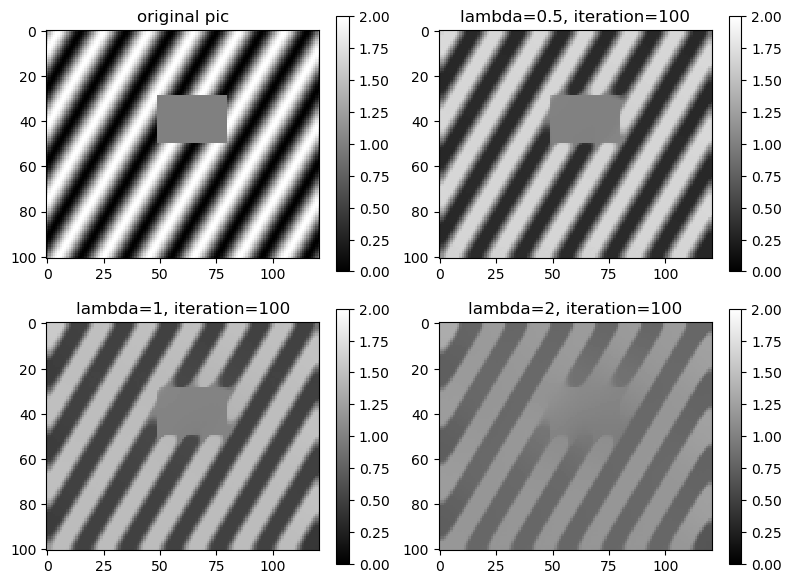

In [5]:
figure(figsize=(8,6))

subplot(221)
imshow(g, cmap="gray"); title("original pic"); colorbar(); clim(0, 2)

subplot(222)
imshow(u1, cmap="gray"); title("lambda=0.5, iteration=100"); colorbar(); clim(0, 2)

subplot(223)
imshow(u2, cmap="gray"); title("lambda=1, iteration=100"); colorbar(); clim(0, 2)

subplot(224)
imshow(u3, cmap="gray"); title("lambda=2, iteration=100"); colorbar(); clim(0, 2)

tight_layout()

In [6]:
# vector projection to S_\infty ball
function vec_proj(pp, lambda)
    for i = 1:size(pp,1)
        for j = 1:size(pp,2)
            P = pp[i,j,:,:]
            U, S, V = svd(P)
            SS = min.(S, lambda)
            PP = U * diagm(SS) * V'
            pp[i,j,:,:] = PP
        end
    end
    return pp
end

function PDHG_ROF_vec_S1(g, lambda; iterMax=100, tau=0.1, sigma=1/(tau*8))
    Nx, Ny, Nz = size(g)
    u0 = ones(Nx, Ny, Nz)
    p0 = ones(Nx, Ny, 2, Nz)

    for i = 1:iterMax
        u0_bar = u0 + tau * div_op(p0)
        u1 = (u0_bar + tau*g) ./ (1 + tau)

        p0_bar = p0 + sigma * nabla_op(u1)
        p1 = vec_proj(p0_bar, lambda)

        u0 = copy(u1)
        p0 = copy(p1)

    end
    return u0
end

PDHG_ROF_vec_S1 (generic function with 1 method)

In [7]:
g = zeros(Nx, Ny, 3)

g1 = sin.(2*pi*5*x .+ 2*pi*1*y');
g1 = g1 .+ 1;

g2 = 0.9ones(Nx, Ny)

g2[30:50,50:80] .= 0;
g3 = cos.(2*pi*3*x .+ 2*pi*5*y')

g[:,:,1] = g1
g[:,:,2] = g2
g[:,:,3] = g3

g = (g .- minimum(g)) / (maximum(g) - minimum(g));
# imshow(g)

In [8]:
lambda1 = 1e-1
lambda2 = 5e-1
lambda3 = 1e0
u1 = PDHG_ROF_vec_S1(g, lambda1);
u2 = PDHG_ROF_vec_S1(g, lambda2);
u3 = PDHG_ROF_vec_S1(g, lambda3);


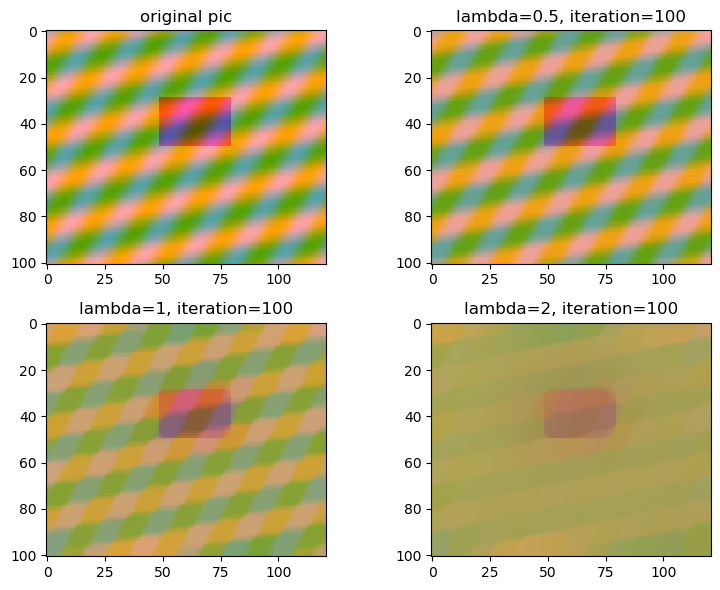

In [9]:
figure(figsize=(8,6))

subplot(221)
imshow(g); title("original pic")

subplot(222)
imshow(u1); title("lambda=0.5, iteration=100")

subplot(223)
imshow(u2); title("lambda=1, iteration=100")

subplot(224)
imshow(u3); title("lambda=2, iteration=100")

tight_layout()

In [10]:
# load data
file = matopen("marmousi_data/marmousi_vp10.mat")
vp10 = read(file, "marmousi_vp10") # note that this does NOT introduce a variable ``varname`` into scope
close(file)

file = matopen("marmousi_data/marmousi_rho10.mat")
rho10 = read(file, "marmousi_rho10") # note that this does NOT introduce a variable ``varname`` into scope
close(file)

Nx = 161
Ny = 161

kernal = 3
c = vp10[61:61+Nx-1,780:780+Ny-1]
c = imfilter(c, Kernel.gaussian(kernal));
c = (c .- minimum(c)) ./ (maximum(c)-minimum(c)) * (maximum(c)-minimum(c)) .+ minimum(c);

rho = rho10[61:61+Nx-1,780:780+Ny-1]
rho = imfilter(rho, Kernel.gaussian(kernal));
rho = (rho .- minimum(rho)) ./ (maximum(rho)-minimum(rho)) * (maximum(rho)-minimum(rho)) .+ minimum(rho);

image = zeros(Nx, Ny, 2)
image[:,:,1] .= c
image[:,:,2] .= rho

cmi = 1 * minimum(c)
cma = maximum(c)
rhomi = 1 * minimum(rho)
rhoma = maximum(rho);

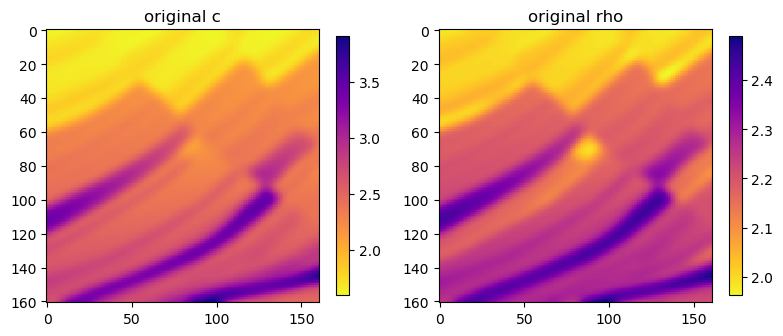

In [11]:
figure(figsize=(8,4))

subplot(121)
imshow(c, cmap="plasma_r"); title("original c"); colorbar(shrink=0.7); clim(cmi, cma)

subplot(122)
imshow(rho, cmap="plasma_r"); title("original rho"); colorbar(shrink=0.7); clim(rhomi, rhoma)

tight_layout()

In [12]:
lambda1 = 5e-1
u1 = PDHG_ROF_vec_S1(image, lambda1);

In [13]:
c_tv1 = PDHG_ROF(c, lambda1);
rho_tv1 = PDHG_ROF(rho, lambda1);

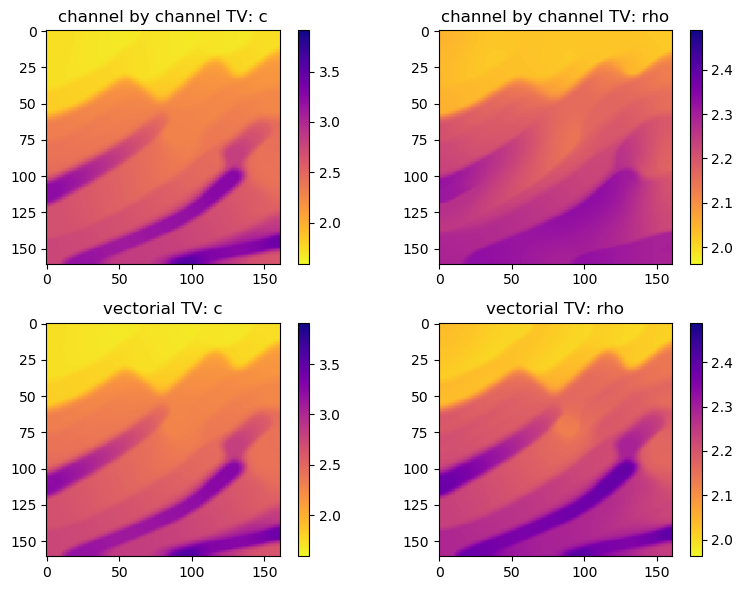

In [14]:
figure(figsize=(8,6))

subplot(221)
imshow(c_tv1, cmap="plasma_r"); title("channel by channel TV: c"); colorbar(); clim(cmi, cma)

subplot(222)
imshow(rho_tv1, cmap="plasma_r"); title("channel by channel TV: rho"); colorbar(); clim(rhomi, rhoma)

subplot(223)
imshow(u1[:,:,1], cmap="plasma_r"); title("vectorial TV: c"); colorbar(); clim(cmi, cma)

subplot(224)
imshow(u1[:,:,2], cmap="plasma_r"); title("vectorial TV: rho"); colorbar(); clim(rhomi, rhoma)

tight_layout()

In [15]:
lambda2 = 2e-1
u2 = PDHG_ROF_vec_S1(image, lambda2);

In [16]:
c_tv2 = PDHG_ROF(c, lambda2);
rho_tv2 = PDHG_ROF(rho, lambda2);

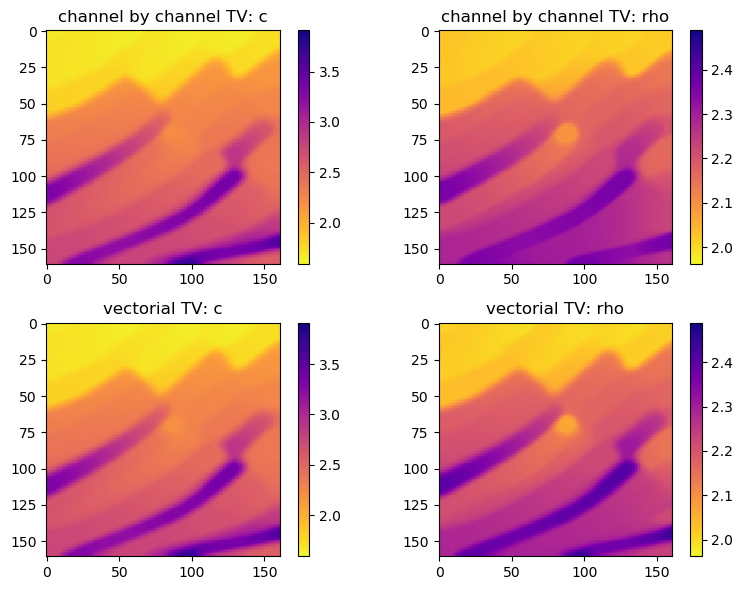

In [17]:
figure(figsize=(8,6))

subplot(221)
imshow(c_tv2, cmap="plasma_r"); title("channel by channel TV: c"); colorbar(); clim(cmi, cma)

subplot(222)
imshow(rho_tv2, cmap="plasma_r"); title("channel by channel TV: rho"); colorbar(); clim(rhomi, rhoma)

subplot(223)
imshow(u2[:,:,1], cmap="plasma_r"); title("vectorial TV: c"); colorbar(); clim(cmi, cma)

subplot(224)
imshow(u2[:,:,2], cmap="plasma_r"); title("vectorial TV: rho"); colorbar(); clim(rhomi, rhoma)

tight_layout()